In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
data = pd.read_csv('./hochgerner_2018.data.gz',sep='\t',index_col=0)
anno = pd.read_csv('./hochgerner_2018.anno',sep='\t',header=None)
anno = anno[1].values


In [5]:
#install seaborn for plotting if you don't have it installed
#!pip install seaborn
import seaborn

In [16]:
#We will first normalize each cell by total count per cell.
percell_sum = data.sum(axis=0)
pergene_sum = data.sum(axis=1)

preprocessed_data = data / percell_sum.values[None, :] * np.median(percell_sum)
preprocessed_data = preprocessed_data.values

#transform the preprocessed_data array by `x := log (1+x)`
preprocessed_data = np.log(1 + preprocessed_data)

#standard scaling
preprocessed_data_mean = preprocessed_data.mean(axis=1)
preprocessed_data_std = preprocessed_data.std(axis=1)
preprocessed_data = (preprocessed_data - preprocessed_data_mean[:, None]) / \
                     preprocessed_data_std[:, None]



In [20]:
#preprocess by PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
pca.fit(preprocessed_data.T)
pca_data = pca.transform(preprocessed_data.T)

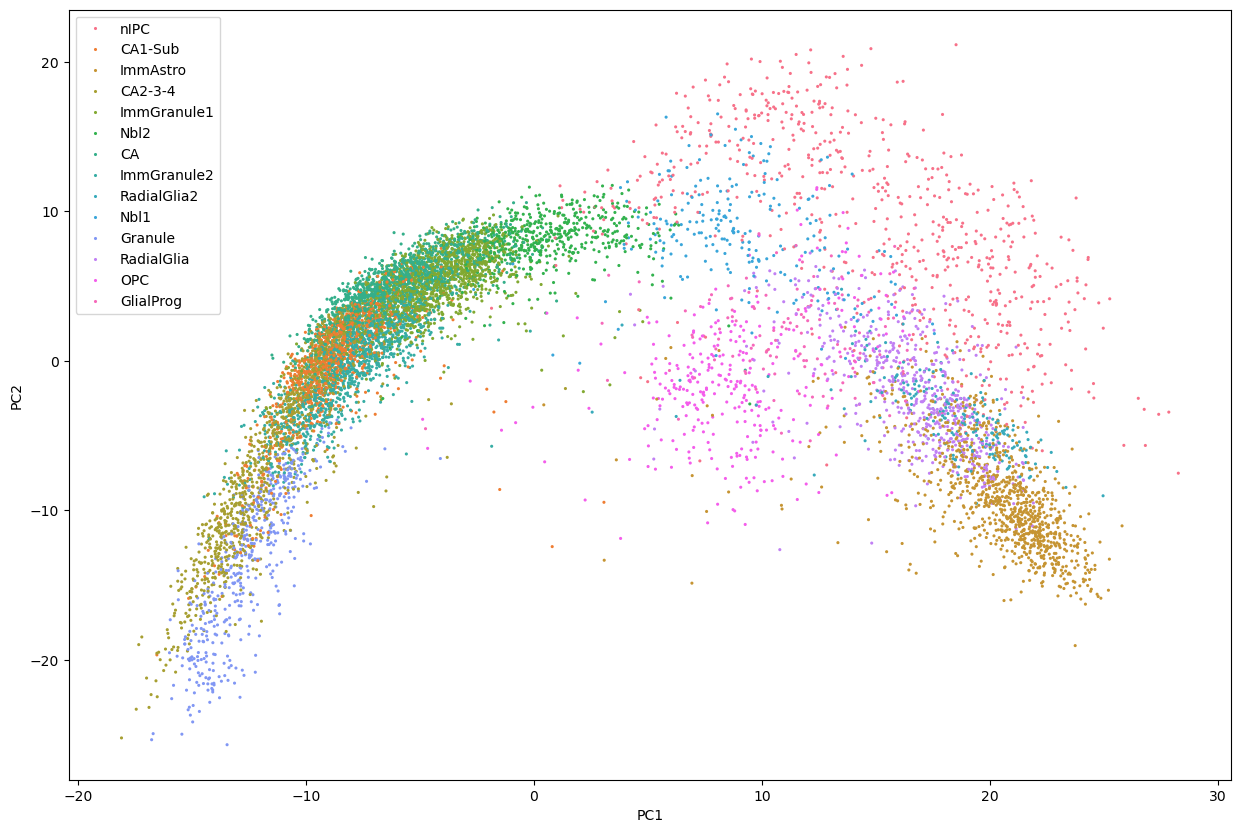

In [21]:
#visualize PCA result
plt.figure(figsize=(15,10))
seaborn.scatterplot(x=pca_data[:,0], y=pca_data[:,1], linewidth = 0, s=5, hue=anno)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

##  GraphDR: nonlinear dimensionality reduction that preserves linear interpretability

GraphDR is a nonlinear dimensionality reduction method that preserves the linear interpretability while improving on cell type representation quality. GraphDR combines the advantages of linear methods such as PCA and nonlinear methods such as t-SNE. Unlike t-SNE, GraphDR is also suitable for comparison across datasets.

In [33]:
#write and apply your own GraphDR implementation here!
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph,eye
from scipy.sparse.linalg import inv
from scipy.linalg import cho_factor, cho_solve
def graphdr(X, n_neighbors=15, lambda_reg=1.0, N_Components=2):
    n_samples = X.shape[0]

    # 1. build KNN graph
    knn_graph = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
    
    # 2. graph Laplace
    L = csgraph.laplacian(knn_graph, normed=False)

    # 3. smooth
    I = eye(n_samples)
    A = I + lambda_reg * L

    # 4.calculate inverse
    # Inv_A = inv(A) 
    # print(A.shape)
    # Inv_A = np.linalg.inv(np.array(A))
    # X_smooth = Inv_A @ X
    # this called  Cholesky decomposition, which is faster and more robust.
    cho = cho_factor(A.toarray())
    X_smooth = cho_solve(cho, X)
    pca = PCA(n_components=N_Components)
    Z = pca.fit_transform(X_smooth)
    return Z


graphdr_data  = graphdr(pca_data, n_neighbors=15, lambda_reg=0.01, N_Components=2)

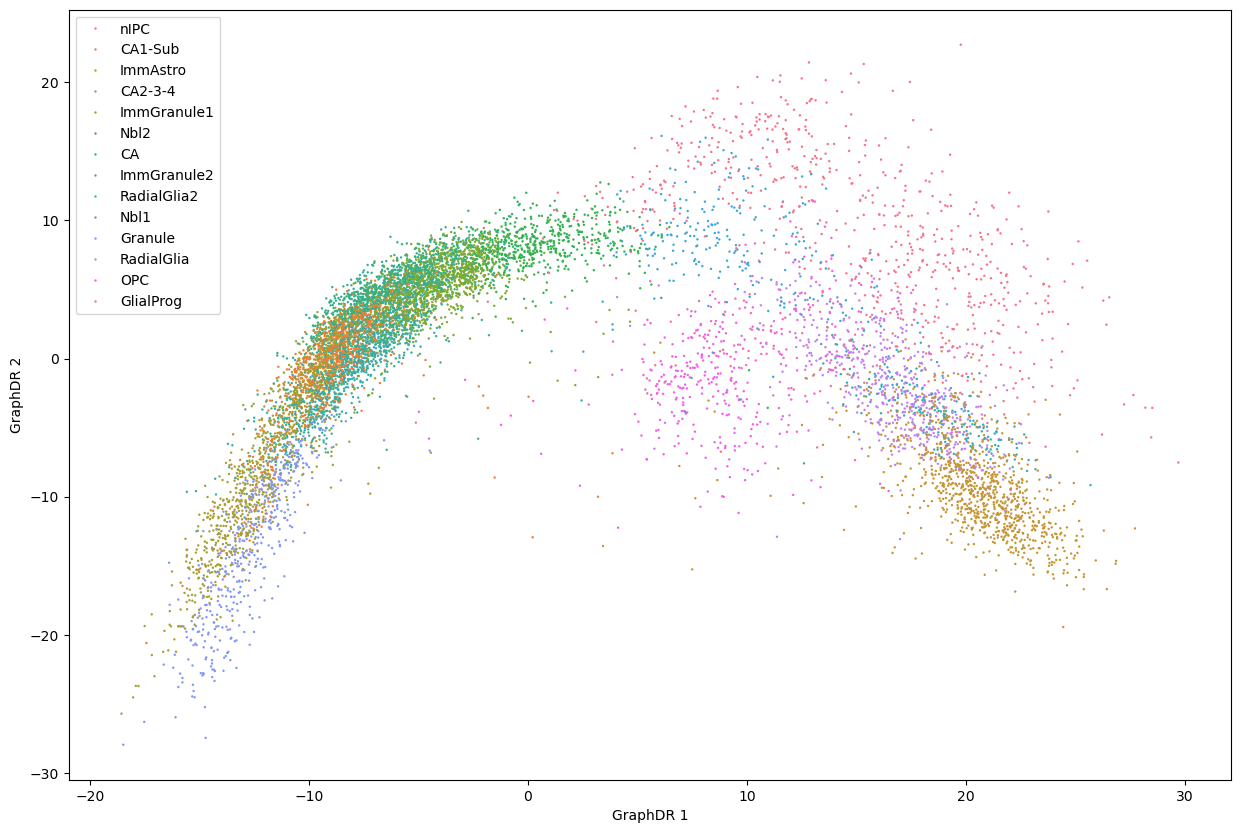

In [34]:
#compare your graphdr output with this one, it should look similar (remember to adjust lambda_ and see its effect)

plt.figure(figsize=(15,10))
seaborn.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')
plt.show()